In [113]:
# Imports 
import pandas as pd
from datetime import datetime
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy import stats


#for LDA:
import gzip
import tarfile
import xml.etree.ElementTree as ET
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

colors = [
    "#FF6B6B", "#F4A261", "#2A9D8F", "#264653", "#E9C46A", "#E76F51", "#A8DADC", "#457B9D", "#1D3557", "#FFE8D6", 
    "#FFB4A2",  
    "#CB997E",  
    "#A5A58D",  
    "#6D6875",  
    "#B5838D",  
    "#81B29A",  
    "#F2CC8F",  
    "#606C38" 
]

focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']

color_dict = dict(zip(focus_countries, colors))

In [114]:
DATA_PATH = 'data'
df_date_clean = pd.read_csv(DATA_PATH + '/df_date_clean.csv')
df_date_clean.head(40)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],United States of America,Thriller
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,['English Language'],United States of America,Mystery
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,['Norwegian Language'],Norway,Crime Fiction
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,['English Language'],United Kingdom,Thriller
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,['German Language'],Germany,Drama
5,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"['Silent film', 'English Language']",United States of America,Short Film
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,['English Language'],South Africa,Family Film
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['English Language'],United States of America,Musical
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,['Spanish Language'],Argentina,Musical
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,['English Language'],United Kingdom,Horror


In [115]:
# function that extracts the meaningful words in each XML file
def parse_corenlp_file(file):
    with gzip.open(file, 'rt', encoding='utf-8') as f:
        tree = ET.parse(f)
        root = tree.getroot()
        filtered_words = []
        for token in root.iter('token'):
            lemma = token.find('lemma').text
            pos = token.find('POS').text
            if pos in {'NN', 'NNS'} or pos.startswith('VB') or pos.startswith('JJ'):
                filtered_words.append(lemma)
        return ' '.join(filtered_words)

In [8]:
#os.chdir(os.path.join(os.getcwd(), "..", ".."))

tar_path = 'data/corenlp_plot_summaries.tar'

documents = []
ids = []


with tarfile.open(tar_path, 'r') as tar:
    for member in tar.getmembers():
        if member.name.endswith('.xml.gz'):
            with tar.extractfile(member) as xml_gz_file:
                film_id = member.name.split('/')[-1].replace('.xml.gz', '')
                ids.append(film_id)
                document = parse_corenlp_file(xml_gz_file)
                documents.append(document)

In [154]:
genres_exploded = df_date_clean.explode('Movie genres')
movie_genres = genres_exploded['Movie genres'].unique()
genre_documents = {genre: [] for genre in movie_genres}
number_films_minimum = 1000 #treshold for the number of films
for index,id in enumerate(ids):
    try:
        id = int(id)
        genre = df_date_clean[df_date_clean['Wikipedia movie ID']== id]['Movie genres'].iloc[0]
        genre_documents[genre].append(documents[index])
    except:
        continue
filter_genre_documents = {cle: valeur for cle, valeur in genre_documents.items() if len(valeur) > number_films_minimum}

In [179]:

filter_genre_documents['Pornographic movie'] = genre_documents['Pornographic movie']


In [177]:
Size_genre = {cle: len(valeur) for cle, valeur in filter_genre_documents.items()}
genre_kept = Size_genre.keys()
genre_kept

dict_keys(['Thriller', 'Crime Fiction', 'Drama', 'Short Film', 'Romantic comedy', 'Romance Film', 'Pornographic movie'])

In [203]:
genre_tokenized_documents = {genre: [] for genre in genre_kept}
genre_dictionary = {genre: [] for genre in genre_kept}
genre_corpus = {genre: [] for genre in genre_kept}
max_freq = 0.3
min_wordcount = 5

for genre in genre_kept:
    if(genre == 'Pornographic movie'):
        min_wordcount = 2
    else :
        min_wordcount = 5
    tokenized_documents = [[word for word in doc.lower().split() if len(word) >= 2] for doc in filter_genre_documents[genre]]
    dictionary = Dictionary(tokenized_documents)
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
    genre_tokenized_documents[genre] = tokenized_documents
    genre_dictionary[genre] = dictionary
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]
    genre_corpus[genre] = corpus


In [192]:
Pornographic_model = LdaMulticore(
    corpus=genre_corpus['Pornographic movie'],
    num_topics=4,
    id2word=genre_dictionary['Pornographic movie'],
    passes=10,
    workers=4,
    random_state=42,
    )

In [199]:
for idx, topic in Pornographic_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

top_terms = []
for topic_id in range(Pornographic_model.num_topics):
    top_terms.append([word for word, prob in Pornographic_model.show_topic(topic_id, topn=5)])
top_terms

Topic 0: 0.108*"film" + 0.083*"show" + 0.039*"police" + 0.039*"seem" + 0.039*"wife" + 0.031*"look" + 0.022*"old" + 0.022*"evict" + 0.022*"try" + 0.022*"fall"
Topic 1: 0.038*"period" + 0.038*"male" + 0.038*"dog" + 0.038*"beach" + 0.021*"fulfil" + 0.021*"long" + 0.021*"hire" + 0.021*"other" + 0.021*"new" + 0.021*"meet"
Topic 2: 0.061*"call" + 0.052*"doctor" + 0.052*"oral" + 0.040*"help" + 0.040*"party" + 0.040*"love" + 0.028*"movie" + 0.028*"job" + 0.028*"lesbian" + 0.028*"hold"
Topic 3: 0.043*"talk" + 0.037*"home" + 0.031*"female" + 0.031*"follow" + 0.030*"friend" + 0.025*"money" + 0.025*"masturbate" + 0.025*"boy" + 0.023*"encounter" + 0.019*"attempt"


[['film', 'show', 'police', 'seem', 'wife'],
 ['period', 'male', 'dog', 'beach', 'fulfil'],
 ['call', 'doctor', 'oral', 'help', 'party'],
 ['talk', 'home', 'female', 'follow', 'friend']]

In [200]:
thriller_model = LdaMulticore(
    corpus=genre_corpus['Thriller'],
    num_topics=4,
    id2word=genre_dictionary['Thriller'],
    passes=10,
    workers=4,
    random_state=42,
    )

In [202]:
for idx, topic in thriller_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.007*"attack" + 0.005*"order" + 0.005*"group" + 0.005*"team" + 0.004*"force" + 0.004*"attempt" + 0.004*"agent" + 0.004*"ship" + 0.004*"shoot" + 0.004*"arrive"
Topic 1: 0.006*"father" + 0.005*"woman" + 0.005*"love" + 0.005*"wife" + 0.005*"mother" + 0.005*"family" + 0.004*"child" + 0.004*"young" + 0.004*"home" + 0.004*"year"
Topic 2: 0.009*"car" + 0.009*"house" + 0.006*"shoot" + 0.006*"run" + 0.005*"arrive" + 0.005*"money" + 0.005*"room" + 0.005*"home" + 0.005*"ask" + 0.005*"gun"
Topic 3: 0.004*"room" + 0.004*"work" + 0.004*"attempt" + 0.004*"know" + 0.003*"alien" + 0.003*"name" + 0.003*"human" + 0.003*"lead" + 0.003*"realize" + 0.003*"body"


In [201]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)

In [5]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.

tokenized_documents = [[word for word in doc.lower().split() if len(word) >= 2] for doc in documents]
dictionary = Dictionary(tokenized_documents)

import random
seed = 42
random.seed(seed)
np.random.seed(seed)
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.3
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 20208
Number of chunks: 42306


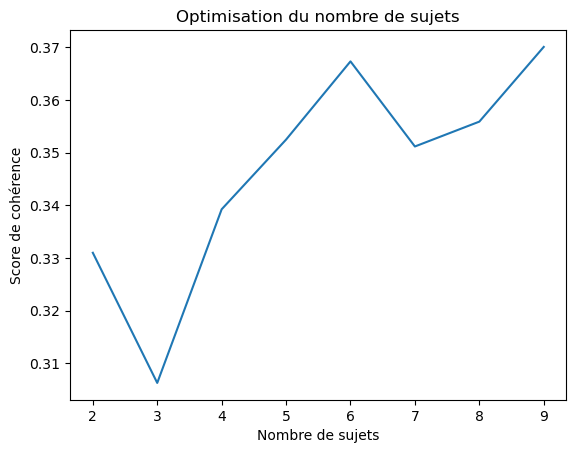

Nombre optimal de sujets : 9
Topic 0: 0.022*"school" + 0.013*"friend" + 0.011*"student" + 0.010*"girl" + 0.010*"boy" + 0.006*"teacher" + 0.006*"other" + 0.006*"new" + 0.006*"team" + 0.005*"father"
Topic 1: 0.011*"play" + 0.010*"show" + 0.009*"story" + 0.009*"movie" + 0.007*"character" + 0.007*"bug" + 0.006*"scene" + 0.006*"song" + 0.005*"music" + 0.005*"star"
Topic 2: 0.009*"kill" + 0.007*"fight" + 0.005*"war" + 0.005*"order" + 0.005*"death" + 0.005*"return" + 0.005*"escape" + 0.004*"lead" + 0.004*"help" + 0.004*"force"
Topic 3: 0.019*"kill" + 0.018*"police" + 0.011*"murder" + 0.009*"money" + 0.009*"shoot" + 0.007*"gang" + 0.006*"tell" + 0.006*"escape" + 0.006*"gun" + 0.005*"drug"
Topic 4: 0.009*"kill" + 0.008*"ship" + 0.007*"attack" + 0.007*"use" + 0.006*"escape" + 0.006*"destroy" + 0.005*"other" + 0.005*"return" + 0.004*"force" + 0.004*"group"
Topic 5: 0.012*"tell" + 0.011*"see" + 0.011*"house" + 0.010*"kill" + 0.007*"body" + 0.006*"room" + 0.006*"night" + 0.006*"come" + 0.006*"begin

In [6]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(
            corpus=corpus,
            num_topics=num_topics,
            id2word=dictionary,
            passes=10,
            workers=4,
            random_state=42,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

start = 2
limit = 10
step = 1 

model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary, corpus=corpus, texts=tokenized_documents, start=start, limit=limit, step=step
)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Nombre de sujets")
plt.ylabel("Score de cohérence")
plt.title("Optimisation du nombre de sujets")
plt.show()

best_num_topics = x[coherence_values.index(max(coherence_values))]
best_model = model_list[coherence_values.index(max(coherence_values))]

print(f"Nombre optimal de sujets : {best_num_topics}")

for idx, topic in best_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

travailler sur un compromis coherence/generalisation ==> oui ok increase # topics ==> increase coherence mais ca decrease la generalisation/interpretabilités ==> elbow methode pour la ou le gain en coherence est réduit

In [7]:
## Of course coherence increases with the number of topics because they are more and more precises, however this highly decreases the interpretability of our analysis. Therefore we choose 4 topics as a compromise between the coherence and the interpetrability of our system.
selected_model = LdaMulticore(
    corpus=corpus,
    num_topics=4,
    id2word=dictionary,
    passes=10,
    workers=4,
    random_state=42,
    )


In [8]:
coherencemodel = CoherenceModel(
model=selected_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v'
)
print("coherence of the selected model:{}".format(coherencemodel.get_coherence()))

coherence of the selected model:0.33591797528285205


In [9]:
top_themes_per_document = []
for i, doc in enumerate(corpus):
    doc_topics = selected_model.get_document_topics(doc, minimum_probability=0)
    sorted_doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    top_indices = [topic_id for topic_id, _ in sorted_doc_topics[:3]]
    top_proportions = [proportion for _, proportion in sorted_doc_topics[:3]]

    top_themes_per_document.append({
        "Wikipedia movie ID": ids[i],
        "Theme 1": top_indices[0],
        "Prop Theme 1": top_proportions[0],
        "Theme 2": top_indices[1],
        "Prop Theme 2": top_proportions[1],
        "Theme 3": top_indices[2],
        "Prop Theme 3": top_proportions[2]
    })

df_top_themes = pd.DataFrame(top_themes_per_document)

df_date_clean['Wikipedia movie ID'] = df_date_clean['Wikipedia movie ID'].astype(str)
df_top_themes['Wikipedia movie ID'] = df_top_themes['Wikipedia movie ID'].astype(str)
merged_df = pd.merge(df_date_clean, df_top_themes, on='Wikipedia movie ID', how='inner')
merged_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,Theme 1,Prop Theme 1,Theme 2,Prop Theme 2,Theme 3,Prop Theme 3
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],United States of America,Thriller,1,0.436704,2,0.427257,3,0.134316
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,['English Language'],United Kingdom,Thriller,3,0.484574,0,0.210879,1,0.172886
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,['German Language'],Germany,Drama,0,0.650697,3,0.345668,1,0.001825
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,['English Language'],South Africa,Family Film,2,0.446808,1,0.283773,0,0.265048
4,6631279,/m/0gffwj,Little city,1997,NaN,93.0,['English Language'],United States of America,Romantic comedy,0,0.988649,3,0.003869,2,0.003747


In [10]:
top_terms = []
for topic_id in range(selected_model.num_topics):
    top_terms.append([word for word, prob in selected_model.show_topic(topic_id, topn=5)])

max_prop_movies = merged_df.loc[merged_df.groupby('Theme 1')['Prop Theme 1'].idxmax()]
max_prop_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,Theme 1,Prop Theme 1,Theme 2,Prop Theme 2,Theme 3,Prop Theme 3
8684,370064,/m/020bv3,Love Actually,2003,246942017.0,136.0,"['French Language', 'Italian Language', 'Portu...",United States of America,Romantic comedy,0,0.998233,3,0.000606,1,0.000585
5194,2550322,/m/07mh2t,Gamera vs. Jiger/Jaiga or Gamera vs. Monster X,1970,NaN,173.0,"['Japanese Language', 'English Language']",Japan,Japanese Movies,1,0.998040,3,0.000661,0,0.000652
29809,10435439,/m/02qd04y,The Warlords,2007,NaN,110.0,"['Chinese language', 'Standard Mandarin', 'Can...",Hong Kong,World cinema,2,0.997557,3,0.000816,0,0.000815
17101,2763171,/m/0818d7,11:14,2003,NaN,85.0,['English Language'],United States of America,Crime Fiction,3,0.998461,0,0.000519,1,0.000513


In [11]:
# Afficher les résultats
for index, row in max_prop_movies.iterrows():
    theme_id = row['Theme 1']
    print(f"Topic {theme_id} with top terms: {top_terms[theme_id]}")
    print(f"Top film for Topic {theme_id}: ID = {row['Wikipedia movie ID']}, Title = {row['Movie name']}\n")

Topic 0 with top terms: ['love', 'friend', 'tell', 'father', 'mother']
Top film for Topic 0: ID = 370064, Title = Love Actually

Topic 1 with top terms: ['use', 'ship', 'other', 'attack', 'destroy']
Top film for Topic 1: ID = 2550322, Title = Gamera vs. Jiger/Jaiga or Gamera vs. Monster X

Topic 2 with top terms: ['kill', 'father', 'son', 'fight', 'family']
Top film for Topic 2: ID = 10435439, Title = The Warlords

Topic 3 with top terms: ['kill', 'tell', 'see', 'police', 'house']
Top film for Topic 3: ID = 2763171, Title = 11:14



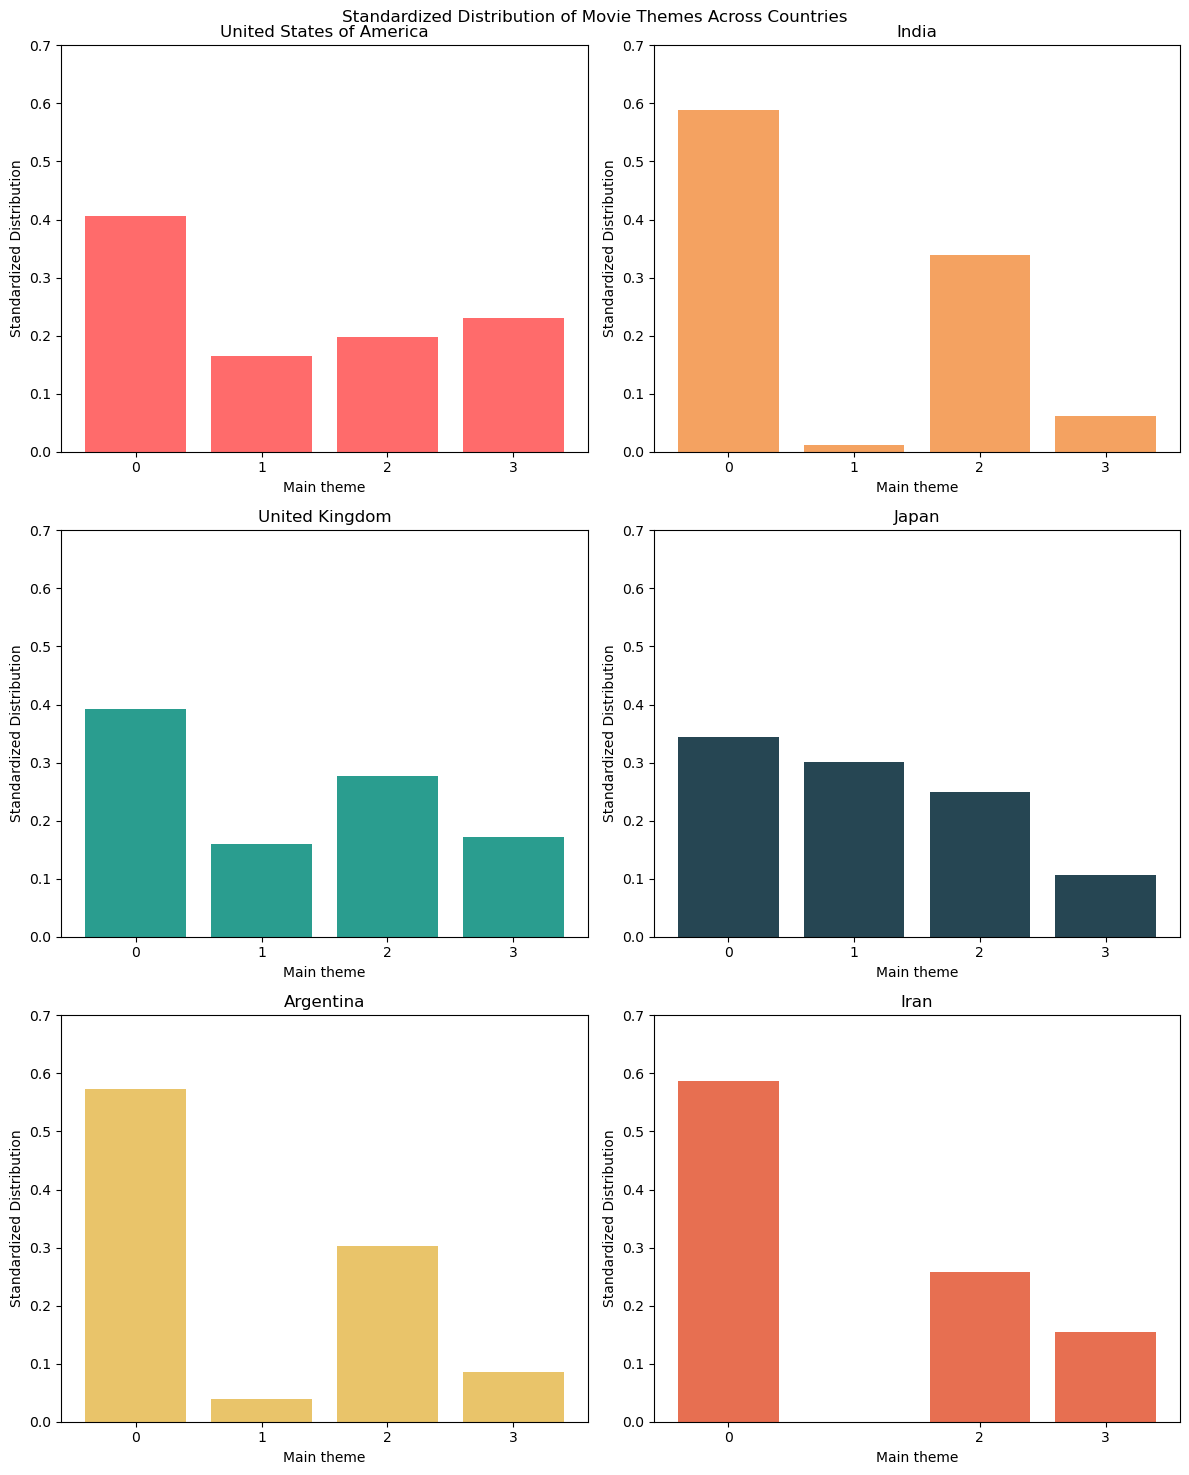

In [12]:

num_columns = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
fig.suptitle('Standardized Distribution of Movie Themes Across Countries')
axes = axes.flatten()

for idx, country in enumerate(focus_countries):
    # Filter movies by country
    movies = merged_df[merged_df['Movie country'] == country]
    
    # Count the main themes (Thème 1) and standardize the counts
    theme_counts = movies['Theme 1'].value_counts()
    theme_counts_stand = theme_counts / theme_counts.sum()
    
    # Plot as a bar chart
    axes[idx].bar(theme_counts_stand.index, theme_counts_stand.values,color=color_dict[country])
    axes[idx].set_title(f"{country}")
    axes[idx].set_xlabel("Main theme")
    axes[idx].set_ylabel("Standardized Distribution")
    axes[idx].set_xticks(theme_counts_stand.index)  # Ensure theme indices show up correctly on x-axis
    axes[idx].set_xticklabels(theme_counts_stand.index)

for ax in axes:
    ax.set_ylim(0, 0.7)

plt.tight_layout()
plt.show()